In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import keras
import csv
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
def read(file):
    with open(file) as f:
        reader = csv.reader(f,delimiter = ';')
        patient_data = []
        data = []
        for row in reader:
            for k in range(len(row)):
                row[k]= int(row[k])
            data.append(row)
    return data

Path to local folder - original dataset from https://archive.ics.uci.edu/ml/datasets/Parkinson+Disease+Spiral+Drawings+Using+Digitized+Graphics+Tablet

In [3]:
path = 'C://Users//Ling//Documents//Code//Datasets//parkinsons - ml//'
hw = []
hw.append([])
hw.append([])
hw.append([])
for f in os.listdir(path+'hw_dataset//control'):
    hw[0].append(read(path+'hw_dataset//control//'+f))
    
for f in os.listdir(path+'hw_dataset//parkinson'):
    hw[1].append(read(path+'hw_dataset//parkinson//'+f))
    
for f in os.listdir(path+'new_dataset//parkinson'):
    hw[2].append(read(path+'new_dataset//parkinson//'+f))

In [4]:
def show_spiral(data,test_num = 0,num=None):
    x = []
    y = []
    for row in data:
        if row[6] == test_num:
            x.append(row[0])
            y.append(row[1])
    fig, ax = plt.subplots()
    ax.plot(x,y,'b-')

    ax.set_title(str(0))
#     plt.plot(x,y,'b-')
    plt.show()

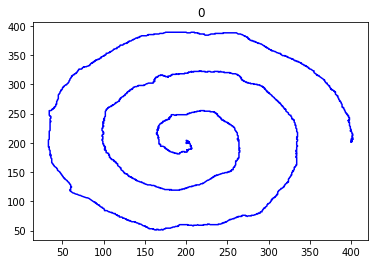

In [5]:
show_spiral(hw[1][0])

In [6]:
count = 0
dfs  = []
for i in range(3):
    for k in range(len(hw[i])):
        df = pd.DataFrame(hw[i][k],columns = ['x','y','z','Pressure','GripAngle','TimeStamp','testID'])
        #first folder is control, everything else is parkinson
        if i == 0:
            isPark = 0
        else:
            isPark = 1
        df['isParkinson'] = pd.Series(np.full((len(df),),isPark))
        df['ID'] = pd.Series(np.full((len(df),),count))
        dfs.append(df)
        count+=1

In [7]:
dfs[0].head()

,x,y,z,Pressure,GripAngle,TimeStamp,testID,isParkinson,ID
0,200,204,0,73,910,1732647300,0,0,0
1,200,204,0,218,900,1732647307,0,0,0
2,200,204,0,253,900,1732647314,0,0,0
3,200,204,0,304,900,1732647321,0,0,0
4,200,204,0,351,900,1732647328,0,0,0


## Reformatting for model input

In [8]:
import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold

In [9]:
#taking only testID == 0
test0 = []
for df in dfs:
    if 0 in df.testID:
        test0.append(df)

In [10]:
y = []
for df in test0:
    y.append(df.loc[0].isParkinson)
    df.drop(['testID','isParkinson','ID','TimeStamp'],axis=1,inplace=True)

In [11]:
test0[0].columns

Index(['x', 'y', 'z', 'Pressure', 'GripAngle'], dtype='object')

In [12]:
lengths= set([])
for df in test0:
    lengths.add(len(df))

In [13]:
x = [df.values for df in test0]

In [14]:
x[0]

array([[200, 204,   0,  73, 910],
       [200, 204,   0, 218, 900],
       [200, 204,   0, 253, 900],
       ...,
       [402, 200,  12, 488, 560],
       [402, 199,  12, 267, 600],
       [403, 198,  24,  58, 630]], dtype=int64)

In [15]:
y = np.array(y)

## Modelling

In [16]:
from keras.models import Sequential
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix
from keras.layers import LSTM, GRU, Dense, Dropout
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint

In [17]:
from numpy.random import seed
seed(7)
from tensorflow import set_random_seed
set_random_seed(7)

In [18]:
def getScores(true,pred):
    print('Accuracy: {}\n'.format(accuracy_score(true,pred)))
    print('Roc: {}\n'.format(roc_auc_score(true,pred)))
    print('F1: {}\n'.format(roc_auc_score(true,pred)))
    print('Confusion Matrix: \n{}'.format(confusion_matrix(true,pred)))
    return([accuracy_score(true,pred),roc_auc_score(true,pred),confusion_matrix(true,pred)])

In [19]:
numRows=4000

In [20]:
tx = pad_sequences(x,padding='post',truncating='post',maxlen=numRows)

In [21]:
train_x, test_x, train_y, test_y = train_test_split(test_x,y,test_size=0.2)

In [40]:
#Cross Validation
kfold = StratifiedKFold(n_splits=10, random_state=7)
scores = []
for train,test in kfold.split(test_x,y):
    m = Sequential()
    m.add(LSTM(100,input_shape=(numRows,5),return_sequences=False))
    m.add(Dense(50))
    m.add(Dense(1, activation ='relu'))
    m.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
    m.fit(test_x[train],y[train],epochs=10,batch_size=10,class_weight={0:5,1:1})
    p = m.predict_classes(test_x[test])
    scores.append(getScores(y[test],p))
    

Epoch 1/10
102/102 [==============================] - 33s 321ms/step - loss: 7.1160 - acc: 0.5098
Epoch 2/10
102/102 [==============================] - 25s 240ms/step - loss: 6.5885 - acc: 0.5588
Epoch 3/10
102/102 [==============================] - 25s 246ms/step - loss: 5.6576 - acc: 0.5392
Epoch 4/10
102/102 [==============================] - 26s 253ms/step - loss: 5.6431 - acc: 0.5294
Epoch 5/10
102/102 [==============================] - 25s 244ms/step - loss: 4.9541 - acc: 0.5196
Epoch 6/10
102/102 [==============================] - 25s 244ms/step - loss: 4.9474 - acc: 0.5098
Epoch 7/10
102/102 [==============================] - 26s 256ms/step - loss: 4.9600 - acc: 0.5098
Epoch 8/10
102/102 [==============================] - 25s 244ms/step - loss: 4.9072 - acc: 0.5490
Epoch 9/10
102/102 [==============================] - 25s 243ms/step - loss: 4.9031 - acc: 0.5686
Epoch 10/10
102/102 [==============================] - 25s 245ms/step - loss: 4.9030 - acc: 0.5098
Accuracy: 0.8333333

In [50]:
sm = []
for s in scores:
    sm.append(s[0])
sum(sm)/len(scores)

0.7277272727272728

In [60]:
x = np.array(sm)
print(x)
x[[-4,-1]]=0.727
print(x)
x.mean()

[0.83333333 0.83333333 0.91666667 1.         0.66666667 0.81818182
 0.09090909 0.90909091 0.90909091 0.3       ]
[0.83333333 0.83333333 0.91666667 1.         0.66666667 0.81818182
 0.727      0.90909091 0.90909091 0.727     ]


0.8340363636363636

In [23]:
m = Sequential()
m.add(LSTM(100,input_shape=(numRows,5),return_sequences=False))
m.add(Dense(50))
m.add(Dense(1, activation ='relu'))
m.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [24]:
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               42400     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 47,501
Trainable params: 47,501
Non-trainable params: 0
_________________________________________________________________


In [25]:
m.fit(train_x,train_y,epochs=10,batch_size=10,class_weight={0:5,1:1})

Epoch 1/10
91/91 [==============================] - 29s 318ms/step - loss: 5.4457 - acc: 0.2967
Epoch 2/10
91/91 [==============================] - 22s 242ms/step - loss: 3.0563 - acc: 0.5385
Epoch 3/10
91/91 [==============================] - 22s 240ms/step - loss: 1.5875 - acc: 0.4286
Epoch 4/10
91/91 [==============================] - 22s 241ms/step - loss: 0.9487 - acc: 0.3846
Epoch 5/10
91/91 [==============================] - 22s 243ms/step - loss: 0.5364 - acc: 0.5604
Epoch 6/10
91/91 [==============================] - 22s 242ms/step - loss: 0.5208 - acc: 0.6264
Epoch 7/10
91/91 [==============================] - 23s 250ms/step - loss: 0.4838 - acc: 0.6374
Epoch 8/10
91/91 [==============================] - 22s 243ms/step - loss: 0.5864 - acc: 0.6264
Epoch 9/10
91/91 [==============================] - 23s 250ms/step - loss: 0.5601 - acc: 0.6484
Epoch 10/10
91/91 [==============================] - 24s 265ms/step - loss: 0.5415 - acc: 0.5934


In [32]:
p= m.predict(np.concatenate(test_x,train_x))
pred = [1 if x>=0.5 else 0 for x in p]

TypeError: only integer scalar arrays can be converted to a scalar index

In [28]:
getScores(test_y,pred)

Accuracy: 0.9130434782608695

Roc: 0.7261904761904762

F1: 0.7261904761904762

Confusion Matrix: 
[[ 1  1]
 [ 1 20]]


[0.9130434782608695, 0.7261904761904762, array([[ 1,  1],
        [ 1, 20]], dtype=int64)]

## Saving the Model

In [35]:
m.save('model_8_20.hdf5')

In [49]:
w = m.get_weights()

In [51]:
for i in w:
    print (i.shape)

(5, 400)
(100, 400)
(400,)
(100, 50)
(50,)
(50, 1)
(1,)


In [45]:
import tensorflow as tf

In [ ]:
from tf import 